In [26]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer, TargetEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid

#import knn classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestClassifier
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error,  mean_squared_error, r2_score, root_mean_squared_error, accuracy_score


### Read in data

In [27]:
train = pd.read_csv('data/train.csv')
train2 = pd.read_csv('data/training_extra.csv')
test = pd.read_csv('data/test.csv')


In [28]:
train = pd.concat([train, train2], axis=0)
train.reset_index(inplace=True, drop=True)
train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [29]:
def create_submission_file(sub_df):
    submission = pd.read_csv("data/sample_submission.csv")
    submission["Price"] = sub_df["price"]
    display(submission.head(2))
    file_name = datetime.now().strftime('submissions/submission_%Y%m%d_%H%M.csv')
    submission.to_csv(file_name, index = False)

### Exploratory

In [30]:
train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [31]:
test.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


From initial observation it looks like we will need to encode categorical variables, and binary encode yes no variables. There are also missing values that we should deal with, but there may be some patterns that can help us with that. 

### Duplicate Values

In [32]:
# find duplicates 
train.duplicated().sum()

0

In [33]:
test.duplicated().sum()

0

In [34]:
# just in case 
print(train.shape, test.shape)
train = train.drop_duplicates()
test = test.drop_duplicates()
print(train.shape, test.shape)

(3994318, 11) (200000, 10)
(3994318, 11) (200000, 10)


### Missing Values

In [35]:
train.isna().sum(axis=0) / train.shape[0]

id                      0.000000
Brand                   0.031735
Material                0.027780
Size                    0.021977
Compartments            0.000000
Laptop Compartment      0.024668
Waterproof              0.023615
Style                   0.026082
Color                   0.033452
Weight Capacity (kg)    0.000453
Price                   0.000000
dtype: float64

In [36]:
test.isna().sum(axis=0) / test.shape[0]

id                      0.000000
Brand                   0.031135
Material                0.028065
Size                    0.021905
Compartments            0.000000
Laptop Compartment      0.024810
Waterproof              0.024055
Style                   0.025765
Color                   0.033925
Weight Capacity (kg)    0.000385
dtype: float64

Always less than ~3% missing values, so thats a good sign. 

### Encode variables

we create new columns for encoded variables and retain the original columns

In [37]:
# import categorical encoder

cat_cols = ['Brand', 'Material', 'Size', 'Style', 'Color']

for col in cat_cols:
    train[col + '_enc'] = train[col].astype('category').cat.codes
    test[col + '_enc'] = test[col].astype('category').cat.codes


In [38]:
binary_cols = ['Laptop Compartment', 'Waterproof']

mapping = {'Yes': 1, 'No': 0}

train[binary_cols] = train[binary_cols].map(mapping.get)
test[binary_cols] = test[binary_cols].map(mapping.get)

### Feature Imputation

In [39]:
train.dtypes

id                        int64
Brand                    object
Material                 object
Size                     object
Compartments            float64
Laptop Compartment      float64
Waterproof              float64
Style                    object
Color                    object
Weight Capacity (kg)    float64
Price                   float64
Brand_enc                  int8
Material_enc               int8
Size_enc                   int8
Style_enc                  int8
Color_enc                  int8
dtype: object

In [40]:
num_cols = test.select_dtypes(include=['number']).columns
num_cols

Index(['id', 'Compartments', 'Laptop Compartment', 'Waterproof',
       'Weight Capacity (kg)', 'Brand_enc', 'Material_enc', 'Size_enc',
       'Style_enc', 'Color_enc'],
      dtype='object')

In [41]:
imputer = IterativeImputer(max_iter=10, random_state=42)

impute_cols = ['Compartments', 'Brand_enc', 'Material_enc', 'Size_enc', 'Style_enc', 'Color_enc', 'Weight Capacity (kg)', 'Laptop Compartment', 'Waterproof']

train[impute_cols] = pd.DataFrame(imputer.fit_transform(train[impute_cols]), columns=impute_cols)

test[impute_cols] = pd.DataFrame(imputer.transform(test[impute_cols]), columns=impute_cols)


### Feature Engineering

In [42]:
def engineer_features(df, is_train_set=False):

    # first create price bins
    if is_train_set:
        df['round_price'] = df.Price.astype(int)
        binner = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
        binned_values = binner.fit_transform(df[['round_price']]).astype(int).flatten()

        # Create bin category column
        bin_col_name = f"price_cat"
        df[bin_col_name] = binned_values

    df['weight_capacity_rounded'] = df['Weight Capacity (kg)'].apply(lambda x: round(x))
    
    binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
    binned_values = binner.fit_transform(df[['weight_capacity_rounded']]).astype(int).flatten()

    # Create bin category column
    bin_col_name = f"weight_capacity_bins"
    df[bin_col_name] = binned_values

    df['brand_material'] = df['Brand'] + '_' + df['Material']
    df['brand_material'] = df['brand_material'].astype('category').cat.codes

    df['brand_size'] = df['Brand'] + '_' + df['Size']
    df['brand_size'] = df['brand_size'].astype('category').cat.codes

    df['style_size'] = df['Style'] + '_' + df['Size']
    df['style_size'] = df['style_size'].astype('category').cat.codes

    df['style_material'] = df['Style'] + '_' + df['Material']
    df['style_material'] = df['style_material'].astype('category').cat.codes

    df['color_material'] = df['Color'] + '_' + df['Material']
    df['color_material'] = df['color_material'].astype('category').cat.codes

    df['weight_capacity_ratio'] = df['Weight Capacity (kg)'] / df['Weight Capacity (kg)'].max()

    df['weight_to_compartments'] = df['Weight Capacity (kg)'] / (df['Compartments'] + 1)

    df['compartments_bins'] = pd.cut(df['Compartments'], bins=[0, 2, 5, 10, np.inf], labels=['Few', 'Moderate', 'Many', 'Very Many'])
    df['compartments_bins'] = df['compartments_bins'].astype('category').cat.codes

    columns = [col.lower() for col in df.columns]
    df.columns = columns

    df = df.drop(columns=['brand', 'material', 'size', 'style', 'color'])

    df = df.rename({'weight capacity (kg)':'weight_capacity'})

    return df 

train = engineer_features(train.copy(), True)
test = engineer_features(test.copy())



In [43]:
train.columns

Index(['id', 'compartments', 'laptop compartment', 'waterproof',
       'weight capacity (kg)', 'price', 'brand_enc', 'material_enc',
       'size_enc', 'style_enc', 'color_enc', 'round_price', 'price_cat',
       'weight_capacity_rounded', 'weight_capacity_bins', 'brand_material',
       'brand_size', 'style_size', 'style_material', 'color_material',
       'weight_capacity_ratio', 'weight_to_compartments', 'compartments_bins'],
      dtype='object')

In [44]:
# get all numerical columns 
num_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
num_cols.remove('price')
num_cols.remove('round_price')
num_cols.remove('price_cat')
num_cols.remove('id')
num_cols

['compartments',
 'laptop compartment',
 'waterproof',
 'weight capacity (kg)',
 'brand_enc',
 'material_enc',
 'size_enc',
 'style_enc',
 'color_enc',
 'weight_capacity_rounded',
 'weight_capacity_bins',
 'weight_capacity_ratio',
 'weight_to_compartments']

In [45]:

for col in num_cols:
    enc = TargetEncoder(smooth="auto")
    train[col + '_te'] = enc.fit_transform(train[[col]], train['price'])  
    test[col + '_te'] = enc.transform(test[[col]])


In [46]:
train.columns

Index(['id', 'compartments', 'laptop compartment', 'waterproof',
       'weight capacity (kg)', 'price', 'brand_enc', 'material_enc',
       'size_enc', 'style_enc', 'color_enc', 'round_price', 'price_cat',
       'weight_capacity_rounded', 'weight_capacity_bins', 'brand_material',
       'brand_size', 'style_size', 'style_material', 'color_material',
       'weight_capacity_ratio', 'weight_to_compartments', 'compartments_bins',
       'compartments_te', 'laptop compartment_te', 'waterproof_te',
       'weight capacity (kg)_te', 'brand_enc_te', 'material_enc_te',
       'size_enc_te', 'style_enc_te', 'color_enc_te',
       'weight_capacity_rounded_te', 'weight_capacity_bins_te',
       'weight_capacity_ratio_te', 'weight_to_compartments_te'],
      dtype='object')

### Scale data

In [47]:
X_cols = ['compartments', 'laptop compartment', 'waterproof',
       'weight capacity (kg)', 'brand_enc', 'material_enc',
       'size_enc', 'style_enc', 'color_enc', 
       'weight_capacity_rounded', 'weight_capacity_bins', 'brand_material',
       'brand_size', 'style_size', 'style_material', 'color_material',
       'weight_capacity_ratio', 'weight_to_compartments', 'compartments_bins',
       'compartments_te', 'laptop compartment_te', 'waterproof_te',
       'weight capacity (kg)_te', 'brand_enc_te', 'material_enc_te',
       'size_enc_te', 'style_enc_te', 'color_enc_te',
       'weight_capacity_rounded_te', 'weight_capacity_bins_te',
       'weight_capacity_ratio_te', 'weight_to_compartments_te']

y_cols = ['price','price_cat','round_price']

In [48]:
# scale the test and train sets 

scaler = StandardScaler()

train[X_cols] = pd.DataFrame(scaler.fit_transform(train[X_cols]), columns=X_cols)
test[X_cols] = pd.DataFrame(scaler.transform(test[X_cols]), columns=X_cols)


### Model Training - Base Model

In [49]:
X = train[X_cols]
y = train['price']

In [50]:
def eval_xgb(xgb_params):
    # Setup K-Fold Cross-Validation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    best_score = float('inf')
    best_params = None

    model = None

    # Iterate over parameter combinations
    for params in ParameterGrid(xgb_params):
        scores = []
        
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Train the model
            model = xgb.XGBRegressor(**params, objective='reg:squarederror')
            model.fit(X_train, y_train)
            
            # Evaluate on validation set
            preds = model.predict(X_val)
            score = root_mean_squared_error(y_val, preds)
            scores.append(score)
        
        # Average score across folds
        avg_score = np.mean(scores)
        
        # Keep track of the best parameters
        if avg_score < best_score:
            best_score = avg_score
            best_params = params

    print("Best Parameters:", best_params)
    print("Best RMSE: {:.2f}%".format(best_score * 100))

    return model

In [51]:

# Parameter grids for each model
xgb_params = {
    'n_estimators': [ 10, 20, 50],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3,4,5]
}

lgb_params = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.1],
    'num_leaves': [40]
}

cb_params = {
    'iterations': [700],
    'learning_rate': [0.1],
    'depth': [4]
}

rf_params = {
    'n_estimators': [300],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

# Initialize the models
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
lgb_model = lgb.LGBMRegressor(random_state=42, objective='regression', metric='rmse')
cb_model = cb.CatBoostRegressor(verbose=0, random_state=42, loss_function='RMSE')
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)


# Grid search setups
def run_grid_search(model, params, name, scoring='neg_root_mean_squared_error', X=X, y=y):
    grid = GridSearchCV(model, params, cv=3, scoring=scoring, n_jobs=-1)
    grid.fit(X, y)
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"Best score for {name}: {-grid.best_score_}")
    return grid.best_estimator_


In [53]:

print("Running GridSearch for XGBoost...")
best_xgb = eval_xgb(xgb_params)


Running GridSearch for XGBoost...
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best RMSE: 3869.04%


In [54]:

print("Running GridSearch for LightGBM...")
best_lgb = run_grid_search(lgb_model, lgb_params, "LightGBM")

Running GridSearch for LightGBM...


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 2662879, number of used features: 32
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.290086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And

KeyboardInterrupt: 

In [52]:

print("Running GridSearch for CatBoost...")
best_cb = run_grid_search(cb_model, cb_params, "CatBoost")


Running GridSearch for CatBoost...
Best parameters for CatBoost: {'depth': 4, 'iterations': 700, 'learning_rate': 0.1}
Best score for CatBoost: 38.678686489831854


In [56]:
test['price_xgb'] = best_xgb.predict(test[X_cols])
#test['price_lgb'] = best_lgb.predict(test[X_cols])
test['price_cb'] = best_cb.predict(test[X_cols])

#test['price_avg'] = (test['price_xgb'] + test['price_lgb'] + test['price_cb']) / 3

# de log the price
#test_scaled['price'] = np.expm1(test_scaled['price'])

In [57]:
test['price'] = test['price_cb']

In [58]:
create_submission_file(test)

,id,Price
0,300000,81.942656
1,300001,83.034371


#### Feature Importance for Cat Boost Regressor

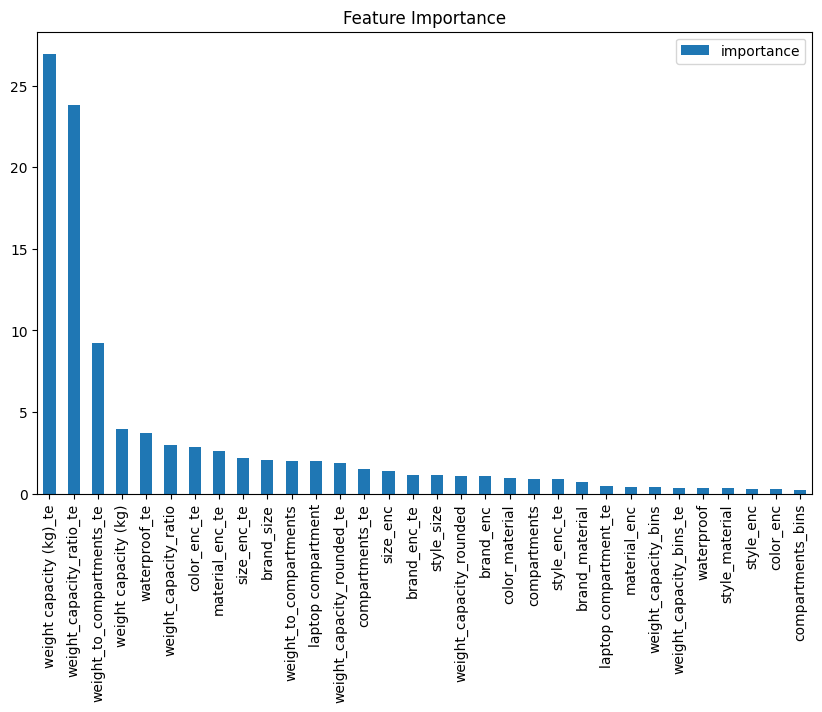

In [55]:
#plot feature importance of cat boost regressor

feature_importances = pd.DataFrame(best_cb.feature_importances_, index=X_cols, columns=['importance']).sort_values('importance', ascending=False)

feature_importances.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importance')
plt.show()

In [14]:
from scipy.optimize import minimize


def find_optimal_weights(best_xgb, best_cb, best_lgb, X_val, y_val):
    """
    Find optimal weights for ensemble predictions of three models.

    Parameters:
    - best_xgb: Trained XGBoost model
    - best_cb: Trained CatBoost model
    - best_lgb: Trained LightGBM model
    - X_val: Validation feature set (numpy array or DataFrame)
    - y_val: True target values (numpy array or Series)

    Returns:
    - Optimal weights as a numpy array
    """
    # Get model predictions
    preds_xgb = best_xgb.predict(X_val)
    preds_cb = best_cb.predict(X_val)
    preds_lgb = best_lgb.predict(X_val)
    
    # Combine predictions into a matrix
    preds_matrix = np.column_stack((preds_xgb, preds_cb, preds_lgb))

    # Define the objective function (MSE)
    def objective(weights):
        # Ensure the weights sum to 1
        weights = np.array(weights)
        weights /= np.sum(weights)
        # Weighted ensemble prediction
        ensemble_preds = np.dot(preds_matrix, weights)
        return np.mean((ensemble_preds - y_val) ** 2)

    # Initial weights (equal distribution)
    initial_weights = [1/3, 1/3, 1/3]

    # Constraints: weights must sum to 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

    # Bounds for weights: each between 0 and 1
    bounds = [(0, 1) for _ in range(3)]

    # Minimize the objective function
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)

    if result.success:
        return result.x
    else:
        raise ValueError("Optimization failed: " + result.message)

In [15]:
find_optimal_weights(best_xgb, best_cb, best_lgb, X, y)

array([1.44328993e-15, 3.27515792e-15, 1.00000000e+00])

In [18]:
test_scaled['price'] = test_scaled['price_avg']
create_submission_file(test_scaled)

,id,Price
0,300000,82.239722
1,300001,82.361883


In [19]:
test_scaled['price'] = test_scaled['price_lgb']
create_submission_file(test_scaled)

,id,Price
0,300000,81.942329
1,300001,82.462474


In [ ]:
06/29/1966

